In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import os

print(f"pandas version : {pd.__version__}")
print(f"numpy version : {np.__version__}")

pandas version : 1.1.5
numpy version : 1.19.5


In [3]:
train = pd.read_csv(os.path.join("data_set", "labeledTrainData.tsv"), delimiter="\t")
test = pd.read_csv(os.path.join("data_set", "testData.tsv"), delimiter="\t")
unlabel_train = pd.read_csv(os.path.join("data_set", "unlabeledTrainData.tsv"), delimiter="\t", error_bad_lines=False)

b'Skipping line 43043: expected 2 fields, saw 3\n'


In [4]:
train = train.drop(["id"], axis=1)
test = test.drop(["id"], axis=1)
unlabel_train = unlabel_train.drop(["id"], axis=1)

In [5]:
train.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
test.head()

,review
0,Naturally in a film who's main themes are of m...
1,This movie is a disaster within a disaster fil...
2,"All in all, this is a movie for kids. We saw i..."
3,Afraid of the Dark left me with the impression...
4,A very accurate depiction of small time mob li...


In [7]:
unlabel_train.head()

,review
0,"Watching Time Chasers, it obvious that it was ..."
1,I saw this film about 20 years ago and remembe...
2,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,I went to see this film with a great deal of e...
4,"Yes, I agree with everyone on this site this m..."


In [8]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk

print(f"nltk version : {nltk.__version__}\n")
nltk.download("stopwords")

nltk version : 3.5

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kitae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def preprocessing(sentence):
    soup = BeautifulSoup(sentence, "html.parser")
    import re
    cleaned = (re.sub("[^a-zA-Z]", " ", soup.text)).lower()
    eng_dict = stopwords.words("english")
    cleaned_arr = [word for word in cleaned.split() if word not in eng_dict]
    return " ".join(cleaned_arr)

In [10]:
preprocessing(train["review"][0])

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [11]:
all_review = pd.concat([train["review"], test["review"], unlabel_train["review"]])
all_review_cleaned = all_review.apply(preprocessing)

In [12]:
all_review_cleaned.sample(5)

14254    jesus franco director made dozens horror soft ...
26153    best cartoon ever saw james rang crazy film u ...
15817    think quite possibly worst movie ever seen kep...
21307    waste hoping film recreate kind claustrophobic...
11751    abomination heinous repulsive reprehensible ex...
Name: review, dtype: object

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
vectorizer = CountVectorizer(analyzer="word", max_features=5000)
all_review_vectorizer = vectorizer.fit_transform(all_review_cleaned)

In [15]:
all_review_vectorizer.shape

(99998, 7000)

In [16]:
train_sentence = all_review_vectorizer[:len(train)]
test_sentence = all_review_vectorizer[-len(test):]

In [17]:
print(train_sentence.shape)
print(test_sentence.shape)

(25000, 7000)
(25000, 7000)


In [18]:
train_labels = train["sentiment"]
train_labels.shape

(25000,)

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=9, n_jobs=-1)

In [21]:
rfc.fit(train_sentence, train_labels)

RandomForestClassifier(max_depth=9, n_estimators=1000, n_jobs=-1)

In [22]:
_predict = rfc.predict(test_sentence)
print(_predict.shape)
_predict

(25000,)


array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [24]:
submission = pd.read_csv(os.path.join("data_set", "sampleSubmission.csv"))
submission.head()

In [25]:
submission["sentiment"] = _predict
submission["sentiment"].value_counts()

1    13579
0    11421
Name: sentiment, dtype: int64

In [26]:
import matplotlib.pyplot as plt

In [35]:
all_sentiment = np.sum(submission["sentiment"].value_counts())
positive = submission["sentiment"].value_counts()[1]
negative = submission["sentiment"].value_counts()[0]
print(positive / all_sentiment)
print(negative / all_sentiment)

12500.0

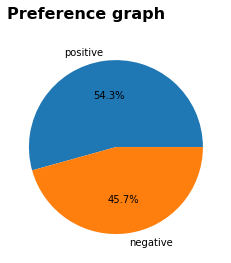

In [28]:
ratio = [positive/all_sentiment, negative/all_sentiment]
labels = ["positive", "negative"]
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title("Preference graph", fontdict=title_font, loc='left', pad=20)
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

In [29]:
import datetime

time_string = datetime.datetime.now().strftime("%Y_%m_%d")
file_name = f"submission-{time_string}.csv"

In [31]:
submission.to_csv(file_name, index=False)